## Tools


In [1]:
def add(a:int,b:int)->int:
    """Add two numbers together
       Args:
       a: The first number
       b: The second number
       Returns:
       The sum of the two numbers
       """
    return a+b

In [11]:
from langchain_core.messages.tool import tool_call
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage,AIMessage
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

llm=ChatGroq(model_name="llama-3.1-8b-instant",api_key=os.getenv("GROQ_API_KEY"))
llm_with_tools=llm.bind_tools([add])
tool_call=llm_with_tools.invoke([HumanMessage(content="What is 2+2?",name="User")])
tool_call.tool_calls



[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': 'wrnh15zkv',
  'type': 'tool_call'}]

In [9]:
### Using messages as state
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated

class State(TypedDict):
	messages:Annotated[list[AnyMessage],add_messages]


## Reducer with add_messages

In [ ]:
initial_messages=[AIMessage(content=f"How can I help you today",name="LLMModel")]
initial_messages.append(HumanMessage(content="I wanna learn about LangGraph",name="User"))
initial_messages

[AIMessage(content='How can I help you today', additional_kwargs={}, response_metadata={}, name='LLMModel'),
 HumanMessage(content='I wanna learn about LangGraph', additional_kwargs={}, response_metadata={}, name='User')]

In [ ]:
## Reducer add_message is to appned instead of ovverride 
ai_message=AIMessage(content="Thats cool😁. What topic are you learning?", name="LLMNodel")
add_messages(initial_messages,ai_message)


[AIMessage(content='How can I help you today', additional_kwargs={}, response_metadata={}, name='LLMModel', id='77e79ea8-b93b-4e75-9d06-ff4b51f31462'),
 HumanMessage(content='I wanna learn about LangGraph', additional_kwargs={}, response_metadata={}, name='User', id='3bcdf3ec-3304-4e00-8260-beab677b78c8'),
 AIMessage(content='Thats cool😁. What topic are you learning?', additional_kwargs={}, response_metadata={}, name='LLMNodel', id='f8f36d3c-71bf-4ed7-b7c0-026789bfd59f')]

In [18]:
## chatbot node functionality
def llm_tool(state:State):
	return {"messages":[llm_with_tools.invoke(state["messages"])]}

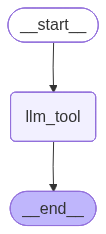

In [19]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
builder=StateGraph(State)
builder.add_node("llm_tool",llm_tool)
builder.add_edge(START, "llm_tool")
builder.add_edge("llm_tool", END)
g=builder.compile()
display(Image(g.get_graph().draw_mermaid_png()))


In [20]:
## Invocation
messages=g.invoke({"messages":"What is 2 plus 2?"})

for message in messages["messages"]:
	message.pretty_print()

================================ Human Message =================================

What is 2 plus 2?
================================== Ai Message ==================================
Tool Calls:
  add (8q5nh9vpa)
 Call ID: 8q5nh9vpa
  Args:
    a: 2
    b: 2


In [21]:
tools=[add]

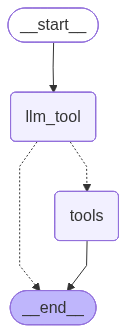

In [22]:
from langgraph.prebuilt import ToolNode,tools_condition

builder=StateGraph(State)
## Add nodes
builder.add_node("llm_tool",llm_tool)
builder.add_node("tools",ToolNode(tools))
## Add edges
builder.add_edge(START,"llm_tool")
builder.add_conditional_edges("llm_tool",
## If the latest from assigned message is a tool call=>tool_condition routes to tools
## If the latest from assigned message is not a tool call=> tool_condition routes to END

tools_condition)
builder.add_edge("tools",END)
g=builder.compile()
display(Image(g.get_graph().draw_mermaid_png()))



In [23]:
## invocation with ToolCalls
messages=g.invoke({"messages":"What is 2 plus 2?"})

for message in messages["messages"]:
	message.pretty_print()

================================ Human Message =================================

What is 2 plus 2?
================================== Ai Message ==================================
Tool Calls:
  add (96c2d25s6)
 Call ID: 96c2d25s6
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

4


In [25]:
## invocation With Another message
messages=g.invoke({"messages":"What is Agentic AI?"})

for message in messages["messages"]:
	message.pretty_print()

================================ Human Message =================================

What is Agentic AI?
================================== Ai Message ==================================

<brave_search>Agentic AI</brave_search>

{"title":"Agentic AI: A New Era of Artificial Intelligence","link":"https://www.forbes.com/sites/forbestechcouncil/2021/04/21/agentic-ai-a-new-era-of-artificial-intelligence/","description":"Agentic AI refers to a new form of artificial intelligence that is designed to mimic human-like behavior and decision-making. It is a type of AI that is capable of taking initiative, making decisions, and interacting with its environment in a way that is similar to humans.","date":"Apr 21, 2021","author":"Forbes Councils Member","publisher":"Forbes"}
